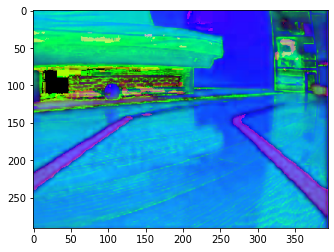

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
import math

tst_pic = cv2.imread('tst.jpg')
tst_hsv = cv2.cvtColor(tst_pic, cv2.COLOR_BGR2HSV)
plt.imshow(tst_hsv)
#plt.imshow(tst_pic)

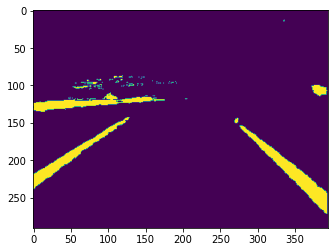

In [2]:
lower_blue = np.array([60, 40, 40])
upper_blue = np.array([150, 255, 255])
mask = cv2.inRange(tst_hsv, lower_blue, upper_blue)
plt.imshow(mask)

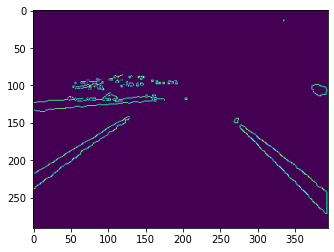

In [3]:
edges = cv2.Canny(mask, 200, 400)
#edges.shape
plt.imshow(edges)

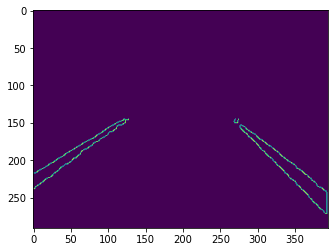

In [4]:
height, width = edges.shape
mask = np.zeros_like(edges)

    
close_vw = np.array([[ (0, height * 1 / 2), 
                      (width, height * 1 / 2), 
                      (width, height), (0, height), ]], np.int32)  #getting bottom half of the image, these calculations may 
# vary incase we change position of camera on dashboard which can clearly effect the quality of data.

cv2.fillPoly(mask, close_vw, 255)
cropped_edges = cv2.bitwise_and(edges, mask)

plt.imshow(cropped_edges)

In [5]:
rho = 1  # distance precision in pixel, i.e. 1 pixel
angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
min_threshold = 10  # minimal of votes
line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength=8, maxLineGap=4)

#line_segments

In [6]:
def make_points(tst_pic, line):
    height, width, _ = tst_pic.shape
    slope, intercept = line
    y1 = height           # bottom of the image
    y2 = int(y1 * 1 / 2)  # make points from middle of the image down

    # Fixing Coordinates
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

lane_lines = []

height, width, _ = tst_pic.shape
left_fit = []
right_fit = []

boundary = 1/3
left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
right_region_boundary = width * boundary       # right lane line segment should be on left 2/3 of the screen

for line_segment in line_segments:
    for x1, y1, x2, y2 in line_segment:
        if x1 == x2:
            logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
            continue
        fit = np.polyfit((x1, x2), (y1, y2), 1)
        slope = fit[0]
        intercept = fit[1]
        if slope < 0:
            if x1 < left_region_boundary and x2 < left_region_boundary:
                left_fit.append((slope, intercept))
        else:
            if x1 > right_region_boundary and x2 > right_region_boundary:
                right_fit.append((slope, intercept))

left_fit_average = np.average(left_fit, axis=0)
if len(left_fit) > 0:
    lane_lines.append(make_points(tst_pic, left_fit_average))

right_fit_average = np.average(right_fit, axis=0)
if len(right_fit) > 0:
    lane_lines.append(make_points(tst_pic, right_fit_average))

logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

print(lane_lines)



 #   If all line slopes are < 0: then we only have detected left lane
 #   If all line slopes are > 0: then we only have detected right lane

[[[-80, 291, 124, 145]], [[432, 291, 268, 145]]]


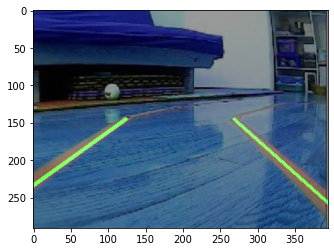

In [7]:
lines = lane_lines
line_color=(0, 255, 0)
line_width=4
line_image = np.zeros_like(tst_pic)
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
line_image = cv2.addWeighted(tst_pic, 0.6, line_image, 1, 1)
plt.imshow(line_image)

In [8]:
_, _, left_x2, _ = lane_lines[0][0]
_, _, right_x2, _ = lane_lines[1][0]
mid = int(width / 2)
x_offset = (left_x2 + right_x2) / 2 - mid
y_offset = int(height / 2)

In [9]:
angle_to_mid_radian = math.atan(x_offset / y_offset)           # angle (in radian) to center vertical line
angle_to_mid_deg = int(angle_to_mid_radian * 180.0 / math.pi)  # angle (in degrees) to center vertical line
steering_angle = angle_to_mid_deg + 90

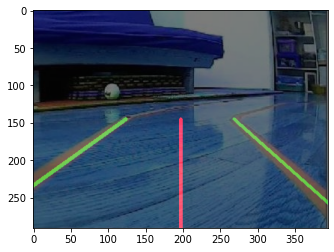

In [10]:
cntr_line_color=(255, 0, 0)

heading_image = np.zeros_like(line_image)
height, width, _ = line_image.shape
steering_angle_radian = steering_angle / 180.0 * math.pi
x1 = int(width / 2)
y1 = height
x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
y2 = int(height / 2)

cv2.line(heading_image, (x1, y1), (x2, y2), cntr_line_color, line_width)
heading_image = cv2.addWeighted(line_image, 0.8, heading_image, 1, 1)


plt.imshow(heading_image)

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right 